In [1]:
#https://www.kaggle.com/code/gabbygab/crop-recommendation-web-application

In [2]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [3]:
import pandas as pd
#import pandas_profiling as pp
#from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import plotly.graph_objects as go
import plotly.io as pio
import pickle
from sklearn.utils import resample
#from sklearn.utils import resample,shuffle
# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

# Validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline

# Tuning
from sklearn.model_selection import GridSearchCV

# Feature Extraction
from sklearn.feature_selection import RFE

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder

# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Ensembles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

warnings.filterwarnings('ignore')


#sns.set_style("whitegrid", {'axes.grid' : False})
pio.templates.default = "plotly_white"


# Analyze Data
def explore_data(df):
    print("Number of Instances and Attributes:", df.shape)
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print('Data types of each columns: ', df.info())
    
# Checking for duplicates
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print("Number of Duplicates: ", count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')
    

# Split training and validation set
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
    
# Spot-Check Algorithms
def GetModel():
    Models = []
    Models.append(('LR'   , LogisticRegression()))
    Models.append(('LDA'  , LinearDiscriminantAnalysis()))
    Models.append(('KNN'  , KNeighborsClassifier()))
    Models.append(('CART' , DecisionTreeClassifier()))
    Models.append(('NB'   , GaussianNB()))
    Models.append(('SVM'  , SVC(probability=True)))
    return Models

def ensemblemodels():
    ensembles = []
    ensembles.append(('AB'   , AdaBoostClassifier()))
    ensembles.append(('GBM'  , GradientBoostingClassifier()))
    ensembles.append(('RF'   , RandomForestClassifier()))
    ensembles.append(( 'Bagging' , BaggingClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    return ensembles

# Spot-Check Normalized Models
def NormalizedModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'normalizer':
        scaler = Normalizer()
    elif nameOfScaler == 'binarizer':
        scaler = Binarizer()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))

    return pipelines

# Train model
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

# Save trained model
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))

# Performance Measure
def classification_metrics(model, conf_matrix):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))
    
# ROC_AUC
def roc_auc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8,6))
    print(f"roc_auc score: {auc(fpr, tpr)*100:.1f}%")
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
    plt.legend()
    plt.show()

In [4]:
df=pd.read_csv('C:/Users/tarnn/Desktop/JK/inno66/OPSA_07_08_66_copy.csv', encoding='latin-1')
df.head()

,KVA,Load_percent,Ia,Ib,Ic,In,UB_percent,Min_V,Max_dis,Load_peak,...,Ib_PEAK,Ic_PEAK,UB_PEAK_percent,Min_V_peak,Copper_Loss,Core_Loss,Line_Loss,Copper_Loss_PEAK,Core_Loss_PEAK,Line_Loss_PEAK
0,160,30.18,101.56,52.27,55.46,47.65,45.577906,225.04,220.10,30.18,...,52.27,55.46,45.577906,225.04,137,187,297,137,187,297
1,160,31.94,90.66,77.99,52.82,32.68,28.450806,217.00,986.34,34.96,...,88.67,55.40,31.449783,215.16,118,187,703,145,187,824
2,250,22.84,107.27,85.01,55.17,44.89,33.113760,222.98,419.05,24.65,...,90.86,65.08,26.909254,222.54,91,259,343,105,268,395
3,250,22.74,108.29,93.30,44.77,56.54,45.482221,223.78,264.14,23.78,...,96.47,45.88,46.591130,222.83,113,259,469,122,259,555
4,250,17.20,76.57,62.83,46.89,25.60,24.488700,226.91,334.66,17.79,...,63.96,48.16,25.430766,226.64,65,259,160,70,268,170


In [5]:
df.shape

(1146, 21)

In [6]:
df = df.drop(['In', 'Ia', 'Ib', 'Ic', 'UB_percent', 'Copper_Loss_PEAK', 'Core_Loss_PEAK', 
              'Line_Loss_PEAK', 'Copper_Loss', 'Core_Loss', 'Line_Loss', 'Min_V', 'UB_PEAK_percent', 'Load_percent'], axis = 1)

In [7]:
df

,KVA,Max_dis,Load_peak,Ia_PEAK,Ib_PEAK,Ic_PEAK,Min_V_peak
0,160,220.10,30.18,101.56,52.27,55.46,225.04
1,160,986.34,34.96,98.38,88.67,55.40,215.16
2,250,419.05,24.65,111.18,90.86,65.08,222.54
3,250,264.14,23.78,115.36,96.47,45.88,222.83
4,250,334.66,17.79,80.56,63.96,48.16,226.64
...,...,...,...,...,...,...,...
1141,100,719.78,7.93,31.71,0.49,0.49,236.91
1142,50,517.77,58.31,45.83,45.71,28.76,235.05
1143,100,950.38,50.26,87.49,59.27,71.03,220.29
1144,250,1064.74,27.11,133.84,68.72,91.19,204.56


# Data Analysis


In [8]:
explore_data(df)

Number of Instances and Attributes: (1146, 7)


Dataset columns: Index(['KVA', 'Max_dis', 'Load_peak', 'Ia_PEAK', 'Ib_PEAK', 'Ic_PEAK',
       'Min_V_peak'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KVA         1146 non-null   int64  
 1   Max_dis     1146 non-null   float64
 2   Load_peak   1146 non-null   float64
 3   Ia_PEAK     1146 non-null   float64
 4   Ib_PEAK     1146 non-null   float64
 5   Ic_PEAK     1146 non-null   float64
 6   Min_V_peak  1146 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 62.8 KB
Data types of each columns:  None


# Checking for Nan Values and duplicates

In [9]:
checking_removing_duplicates(df)

Number of Duplicates:  0
No Duplicate values


In [10]:
#df = df.drop(['PEA'], axis='columns')

In [11]:
df.isna().sum()

KVA           0
Max_dis       0
Load_peak     0
Ia_PEAK       0
Ib_PEAK       0
Ic_PEAK       0
Min_V_peak    0
dtype: int64

# Train model

In [12]:
target ='KVA'
X_train, X_test, y_train, y_test = read_in_and_split_data(df, target)

models = GetModel()
names,results = fit_model(X_train, y_train,models)

LR: 0.982489 (0.014051)
LDA: 0.804575 (0.048529)
KNN: 0.582955 (0.045914)
CART: 0.825191 (0.036272)
NB: 0.538115 (0.057691)
SVM: 0.534914 (0.061294)


# Experiment Different preprocessing techniques

In [13]:
ScaledModel = NormalizedModel('minmax')
name,results = fit_model(X_train, y_train, ScaledModel)

minmaxLR: 0.728046 (0.059807)
minmaxLDA: 0.804575 (0.048529)
minmaxKNN: 0.829658 (0.034486)
minmaxCART: 0.821906 (0.033226)
minmaxNB: 0.538115 (0.057691)
minmaxSVM: 0.895115 (0.038751)
minmaxAB: 0.428882 (0.076583)
minmaxGBM: 0.905005 (0.024977)
minmaxRF: 0.901684 (0.037326)
minmaxET: 0.924630 (0.032006)


In [14]:
ScaledModel = NormalizedModel('standard')
name,results = fit_model(X_train, y_train, ScaledModel)

standardLR: 0.967248 (0.019579)
standardLDA: 0.804575 (0.048529)
standardKNN: 0.839477 (0.035394)
standardCART: 0.824092 (0.036120)
standardNB: 0.538115 (0.057691)
standardSVM: 0.930076 (0.023672)
standardAB: 0.428882 (0.076583)
standardGBM: 0.907191 (0.026020)
standardRF: 0.903882 (0.044881)
standardET: 0.920246 (0.031406)


In [15]:
ScaledModel = NormalizedModel('normalizer')
name,results = fit_model(X_train, y_train, ScaledModel)

normalizerLR: 0.554563 (0.063296)
normalizerLDA: 0.787064 (0.049952)
normalizerKNN: 0.657179 (0.042109)
normalizerCART: 0.804611 (0.035502)
normalizerNB: 0.533791 (0.070633)
normalizerSVM: 0.582991 (0.073678)
normalizerAB: 0.426816 (0.078231)
normalizerGBM: 0.914883 (0.022077)
normalizerRF: 0.907131 (0.032467)
normalizerET: 0.919159 (0.026141)


# Performance Evaluation

Training Accuracy Score: 100.0%
Validation Accuracy Score: 90.0%


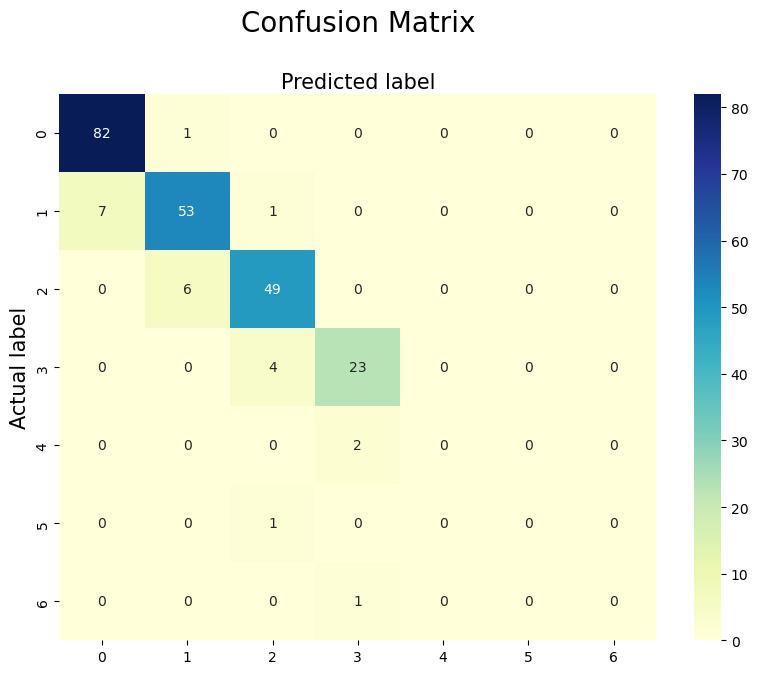

              precision    recall  f1-score   support

          50       0.92      0.99      0.95        83
         100       0.88      0.87      0.88        61
         160       0.89      0.89      0.89        55
         250       0.88      0.85      0.87        27
         315       0.00      0.00      0.00         2
         400       0.00      0.00      0.00         1
         500       0.00      0.00      0.00         1

    accuracy                           0.90       230
   macro avg       0.51      0.51      0.51       230
weighted avg       0.88      0.90      0.89       230



In [16]:
pipeline = make_pipeline(MinMaxScaler(),  ExtraTreesClassifier())
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)

# save model
save_model(model, 'model.pkl')

Training Accuracy Score: 100.0%
Validation Accuracy Score: 90.0%


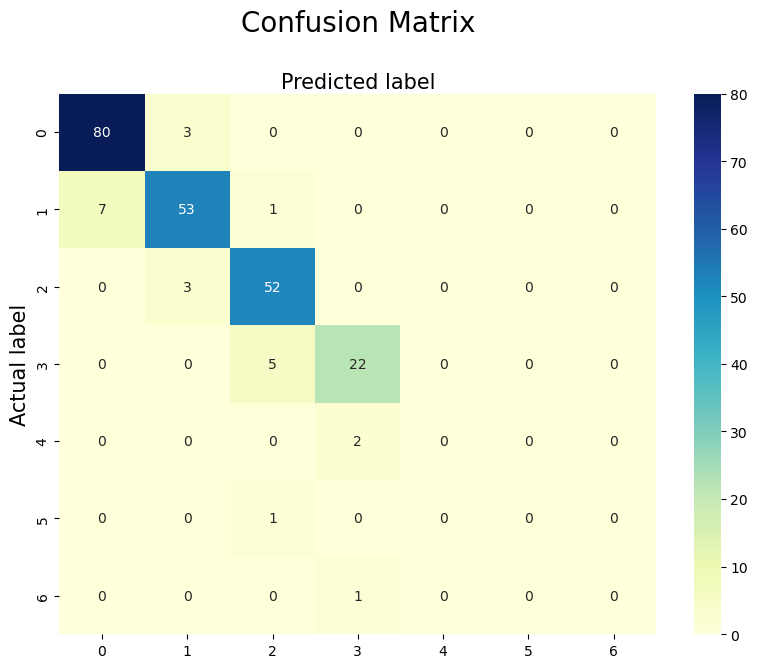

              precision    recall  f1-score   support

          50       0.92      0.96      0.94        83
         100       0.90      0.87      0.88        61
         160       0.88      0.95      0.91        55
         250       0.88      0.81      0.85        27
         315       0.00      0.00      0.00         2
         400       0.00      0.00      0.00         1
         500       0.00      0.00      0.00         1

    accuracy                           0.90       230
   macro avg       0.51      0.51      0.51       230
weighted avg       0.88      0.90      0.89       230



In [17]:
pipeline = make_pipeline(Normalizer(),  ExtraTreesClassifier())
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)

# save model
save_model(model, 'model.pkl')

Training Accuracy Score: 100.0%
Validation Accuracy Score: 90.9%


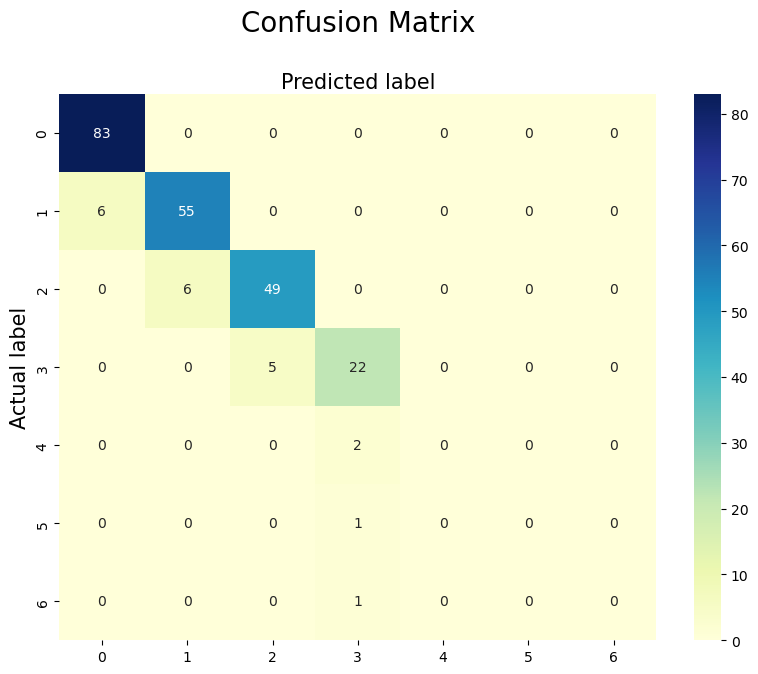

              precision    recall  f1-score   support

          50       0.93      1.00      0.97        83
         100       0.90      0.90      0.90        61
         160       0.91      0.89      0.90        55
         250       0.85      0.81      0.83        27
         315       0.00      0.00      0.00         2
         400       0.00      0.00      0.00         1
         500       0.00      0.00      0.00         1

    accuracy                           0.91       230
   macro avg       0.51      0.52      0.51       230
weighted avg       0.89      0.91      0.90       230



In [18]:
pipeline = make_pipeline(StandardScaler(),  ExtraTreesClassifier())
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)

# save model
save_model(model, 'model.pkl')

# HeatMap

<Axes: >

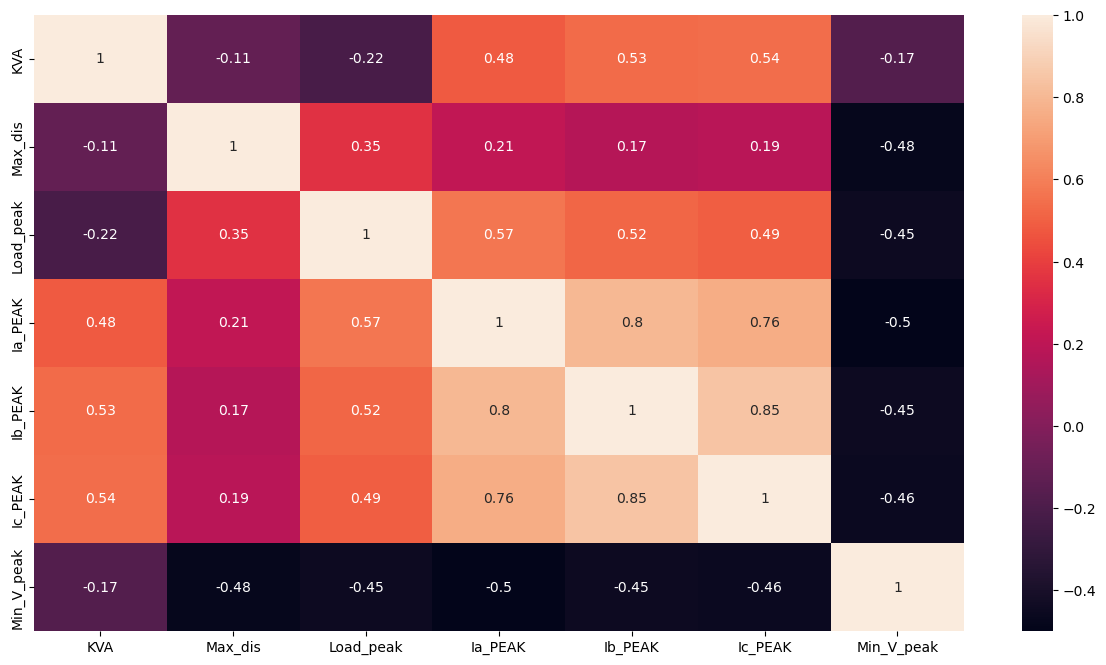

In [19]:
fig = plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), annot = True)

# Pairplot

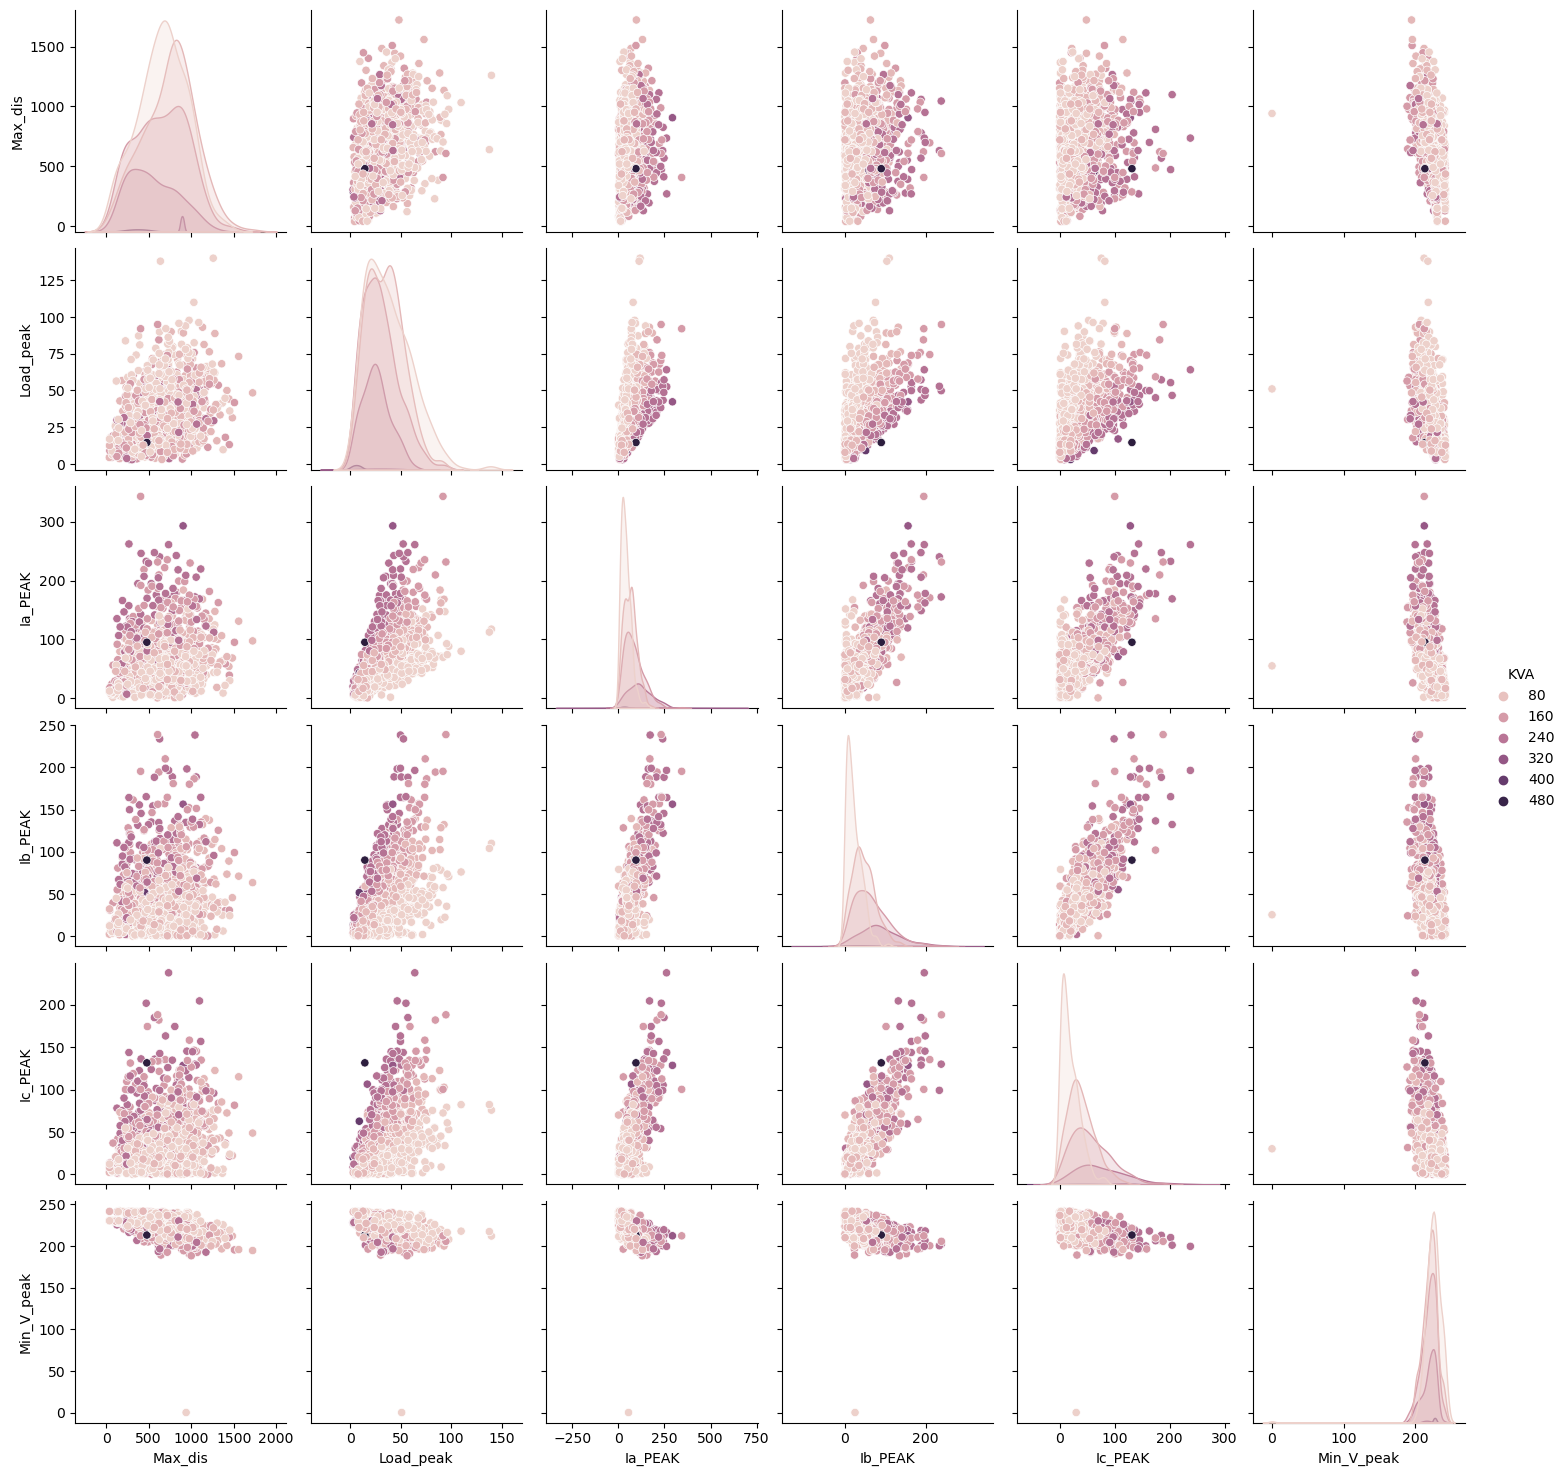

In [29]:
sns.pairplot(df, hue = 'KVA')

# Predict unseen data

In [20]:
#Load_percent = 30.37
#Ia = 59.45
#Ib = 39.70
#Ic = 32.41
#In = 24.17
#UB_percent = 35.56
#Min_V = 223.45
Max_dis = 650
Load_peak = 30.37
Ia_PEAK = 50
Ib_PEAK = 50
Ic_PEAK = 50
#UB_PEAK_percent = 35.56
Min_V_peak = 223.45
#Copper_Loss = 93.00
#Core_Loss = 130.00
#Line_Loss = 348.00
#Copper_Loss_PEAK = 93.00
#Core_Loss_PEAK = 130.00
#Line_Loss_PEAK = 348.00

sample = [Max_dis, Load_peak, Ia_PEAK, 
          Ib_PEAK, Ic_PEAK, Min_V_peak]

#sample = [Load_percent, Ia, Ib, Ic, In, UB_percent, Min_V, Max_dis, Load_peak, Ia_PEAK, 
          #Ib_PEAK, Ic_PEAK, UB_PEAK_percent, Min_V_peak, Copper_Loss, Core_Loss, Line_Loss, Copper_Loss_PEAK, 
          #Core_Loss_PEAK, Line_Loss_PEAK]
single_sample = np.array(sample).reshape(1,-1)
pred = model.predict(single_sample)
#pred.item().title()
pred.item()

100

In [21]:
import streamlit as st 
import pandas as pd
import numpy as np
import os
import pickle
import warnings


st.set_page_config(page_title="Transformer Recommender", page_icon="🌿", layout='centered', initial_sidebar_state="collapsed")

def load_model(modelfile):
    loaded_model = pickle.load(open(modelfile, 'rb'))
    return loaded_model

def main():
    # title
    html_temp = """
    <div>
    <h1 style="color:MEDIUMSEAGREEN;text-align:left;"> Crop Recommendation  🌱 </h1>
    </div>
    """
    st.markdown(html_temp, unsafe_allow_html=True)

    col1,col2  = st.columns([2,2])
    
    with col1: 
        with st.expander(" ℹ️ Information", expanded=True):
            st.write("""
            Crop recommendation is one of the most important aspects of precision agriculture. Crop recommendations are based on a number of factors. Precision agriculture seeks to define these criteria on a site-by-site basis in order to address crop selection issues. While the "site-specific" methodology has improved performance, there is still a need to monitor the systems' outcomes.Precision agriculture systems aren't all created equal. 
            However, in agriculture, it is critical that the recommendations made are correct and precise, as errors can result in significant material and capital loss.

            """)
        '''
        ## How does it work ❓ 
        Complete all the parameters and the machine learning model will predict the most suitable crops to grow in a particular farm based on various parameters
        '''


    with col2:
        st.subheader(" Find out the most suitable Transformer to recommend in your area 👨‍🌾")
        Load_peak = st.number_input("Load", 1,10000)
        Ia = st.number_input("Current Phase A", 1,10000)
        Ib = st.number_input("Current Phase B", 1,10000)
        Ic = st.number_input("Current Phase C",1,10000)
        Min_V_peak = st.number_input("Minimun Voltage",1,10000)

        feature_list = [Load_peak, Ia, Ib, Ic, Min_V_peak]
        single_pred = np.array(feature_list).reshape(1,-1)
        
        if st.button('Predict'):

            loaded_model = load_model('model.pkl')
            prediction = loaded_model.predict(single_pred)
            col1.write('''
            ## Results 🔍 
            ''')
            col1.success(f"{prediction.item().title()} are recommended by the A.I for your area.")
      #code for html ☘️ 🌾 🌳 👨‍🌾  🍃

    st.warning("Note: This A.I application is for educational/demo purposes only and cannot be relied upon. Check the source code [here](https://github.com/gabbygab1233/Crop-Recommendation)")
    hide_menu_style = """
    <style>
    #MainMenu {visibility: hidden;}
    </style>
    """

hide_menu_style = """
        <style>
        #MainMenu {visibility: hidden;}
        </style>
        """
st.markdown(hide_menu_style, unsafe_allow_html=True)

if __name__ == '__main__':
    main()

2023-08-09 04:54:07.064 
  command:

    streamlit run C:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
#แก้ไข streamlit https://github.com/chandrikadeb7/Face-Mask-Detection/pull/145

In [ ]:
#streamlit run C:\Users\tarnn\Desktop\JK\inno66\GIS_Inno_07_08_66_Some_Input_Feature\my_app.py 

In [ ]:
#streamlit run C:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py

In [ ]:
#streamlit run my_app.py 